In [22]:
import jax.numpy as jnp
import jax
import optax
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [90]:
#load the data
data_xi=loadmat('train_xi.mat')
train_xi=data_xi['xi']
train_xi=jnp.array(train_xi,dtype=jnp.float32)
data_Q=loadmat('train_Q.mat')
train_Q=data_Q['Q']
train_Q=jnp.array(train_Q,dtype=jnp.float32)

In [56]:
#initialize parameters
def initialize_parameters(key,num_hidden_layers,hidden_layer_size):
    parameters={}

    for i in range(num_hidden_layers):
        key,subkey=jax.random.split(key)
        weight_shape=(20 if i==0 else hidden_layer_size,hidden_layer_size)
        parameters['W'+str(i+1)]=jax.random.normal(subkey,shape=weight_shape)*0.1
        parameters['b'+str(i+1)]=jax.numpy.zeros((hidden_layer_size,1))
    
    key,subkey=jax.random.split(key)
    weight_shape=(hidden_layer_size,20)
    parameters["W"+str(num_hidden_layers+1)]=jax.random.normal(subkey,shape=weight_shape)*0.1
    parameters['b'+str(num_hidden_layers+1)]=jax.numpy.zeros((20,1))

    return parameters

In [57]:
#forward propagation
def forward_propagation(X,parameters):
    L=len(parameters)//2
    A=X

    for i in range(1,L):
        W=parameters['W'+str(i)]
        b=parameters['b'+str(i)]
        Z=jnp.dot(W.T,A)+b
        A=jax.nn.relu(Z)
    
    W=parameters["W"+str(L)]
    b=parameters["b"+str(L)]
    Z=jnp.dot(W.T,A)+b

    Z=jnp.mean(Z,axis=1,keepdims=True)
    return Z

In [58]:
#cost function
def compute_cost(parameters,X,Q):
    Z=forward_propagation(X,parameters)
    cost=jnp.mean((Z-Q)**2)
    return cost

In [59]:
def minibatches(X,Y,minibatch_size):
    num_batches=X.shape[0]//minibatch_size
    mini_batches_X=[]
    mini_batches_Y=[]
    for i in range(num_batches):
        start=i*minibatch_size
        end=(i+1)*minibatch_size
        mini_batch_X=X[start:end]
        mini_batch_Y=Y[start:end]
        mini_batches_X.append(mini_batch_X)
        mini_batches_Y.append(mini_batch_Y)
    return mini_batches_X,mini_batches_Y

In [88]:
# Build the model
def model(xi_train, Q_train, learning_rate=0.0001, minibatch_size=20,
          num_epochs=700, print_cost=True):
    key = jax.random.PRNGKey(1)
    costs = []
    m = xi_train.shape[0]

    # Initialize parameters
    parameters = initialize_parameters(key, 3, 5)

    # Initialize optimizer using Optax
    optimizer = optax.adam(learning_rate)
    optimizer_state = optimizer.init(parameters)

    for epoch in range(num_epochs):
        total_cost = 0.0
        num_minibatches=m//minibatch_size
        mini_batches_xi,mini_batches_Q=minibatches(xi_train,Q_train,minibatch_size)

        for i in range(num_minibatches):
            mini_batch_xi=mini_batches_xi[i]
            mini_batch_Q=mini_batches_Q[i]

            # Forward propagation
            Z = forward_propagation(mini_batch_xi, parameters)

            # Cost function
            cost=compute_cost(parameters,mini_batch_xi,mini_batch_Q)
            total_cost += cost
            
            # Backward propagation
            # Compute grads
            grads = jax.grad(compute_cost)(parameters,Z,mini_batch_Q)

            # Update parameters using the optimizer
            updates, optimizer_state = optimizer.update(grads, optimizer_state)
            parameters = optax.apply_updates(parameters, updates)

        # Print cost for this epoch
        if print_cost and (epoch + 1) % 100== 0:
            total_cost=jax.device_get(total_cost)
            total_cost=float(total_cost)
            print ("Cost after epoch %i: %f"%(epoch,total_cost))
        if print_cost and (epoch + 1) % 50 == 0:
            costs.append(total_cost)

    plt.plot(costs)
    plt.xlabel("Epochs")
    plt.ylabel("Cost")
    plt.title("Cost vs. Epochs")
    plt.show()
    
    return parameters

Cost after epoch 99: 0.165287
Cost after epoch 199: 0.088186
Cost after epoch 299: 0.044452
Cost after epoch 399: 0.022743
Cost after epoch 499: 0.013817
Cost after epoch 599: 0.010946
Cost after epoch 699: 0.010249


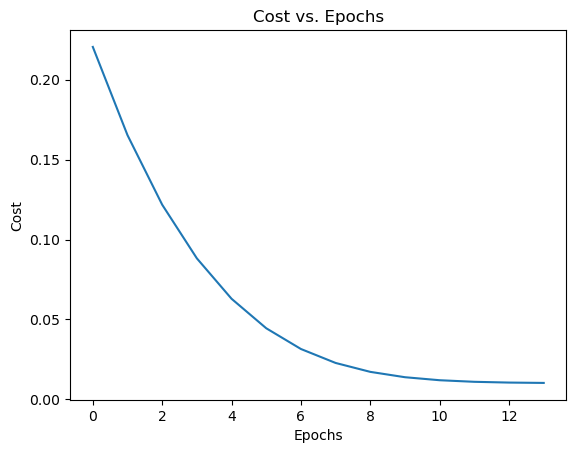

In [89]:
parameters=model(train_xi,train_Q)


# test

In [84]:
#load the test data
data_xi=loadmat('test_xi.mat')
test_xi=data_xi['xi']
test_xi=jnp.array(test_xi,dtype=jnp.float32)

data_Q=loadmat('test_Q.mat')
test_Q=data_Q['Q']
test_Q=jnp.array(test_Q,dtype=jnp.float32)

In [85]:
prediction=forward_propagation(test_xi,parameters)
test_cost=compute_cost(parameters,test_xi,test_Q)
print(test_cost)

0.0012705321
